In [129]:
#%% Librerías
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
#%% Accesar data
class pFinal():
    def __init__(self, dName):
        #Por defecto el valor de currentTraining es SP
        #lastModel y autoModel permiten almacenar los modelos para las distintas equis
        self.lastModel = {}
        self.autoModel = {}
        #currentTraining permite generalizar la seleccion de variables para entrenar
        self.currentTraining = 'SP'
        self.dName = dName
        self.coefs = {}
        #Se carga la data al crear la instancia de la clase pFinal
        fPath = os.getcwd()
        dPath = 'proyecto_data'
        data = np.load(os.path.join(fPath, dPath, self.dName))
        self.data=pd.DataFrame(data, columns=['SP','OQ','1Fsf','TotRMS','Year','LF'])        
    def getStats(self):
        average = dict(self.data.mean(axis = 0))
        maxCol = self.data.max(axis = 0)
        minCol = self.data.min(axis = 0)
        peak = dict(maxCol-minCol)
        maxCol = dict(maxCol)
        minCol = dict(minCol)
        desvEst = dict(self.data.std(axis = 0))
        self.stats = pd.DataFrame(index = ['average','maxCol','minCol','peak','desvEst'],
                     data = (average,maxCol,minCol,peak,desvEst))
    def graphHist(self):
        for i in self.data.columns:
            
            #print(self.data[i])
            hist = sns.displot(self.data[i],kind='hist')
    def r2(self):   
        yav = self.stats['SP']['average']
        ty = self.data['SP'].apply(lambda y: y - yav)
        sumvarY = self.data['SP'].apply(lambda y: (y-yav)**2).sum()
        for i in self.data.columns[1:]:
            #sumxy = (self.data['SP']:self.data[i]).sum()
            xav = self.stats[i]['average']
            num = (self.data[i].apply(lambda x: x - xav)*ty).sum()
            sumvarX = self.data[i].apply(lambda x: (x-xav)**2).sum()
            deno = np.sqrt(sumvarY*sumvarX)
            self.coefs[i] = num/deno
    def plots(self):
        #fig, axs = plt.subplots(5)
        x=0
        for i in self.data.columns[1:]:
            plt.scatter(self.data[i], self.data['SP'], s=0.5, c='r', alpha=0.5)
            #Para tener una mejor referencia se agrega el nombre de la variable al titulo
            plt.title("{} - r2: {}".format(i,self.coefs[i]))
            plt.xlim(self.stats[i]['minCol']-1, self.stats[i]['maxCol']+1)
            plt.show()
    def entrenar(self,x,y,epoch=0,impErr=0,alpha=0):
        #Se obtiene el nombre de la columna ingresada
        #Permite el control de los limites en los ejes de las graficas y
        #los puntos de referencia en la grafica de modelos por iteracion.
        self.currentTraining = x.name
        #Se inicializan los parametros del modelo.
        #betas = np.random.rand(2)
        #b0 es betas[0] y b1 es betass[1]
        betas = [1,1]
        #Iteraciones del entrenamiento.
        errors = []
        models = {}
        for i in range(1,epoch+1):
            #Almacenar modelo
            models[i] = betas
            #Prediccion de y
            x = np.array(x)
            M = np.transpose(np.array([x, np.full_like(x,1)]))
            y = np.array(y)
            yPredict = np.dot(M, betas)
            #Calcular error.
            e = np.sum((y-yPredict)**2)
            errors.append(e)
            if i % impErr == 0:
                #
                #print(self.currentTraining)
                print('Iteracion {}:\n {}'.format(i, e))
            #Grads[0] es el gradiente del error respecto de b1 y Grads[1] de b0
            grads = 1/len(x) * np.dot((yPredict-y),M)
            #Actualización de los parámetros.
            betas = betas - alpha*grads[::-1]
        self.lastModel[self.currentTraining] = betas
        return models, errors
    def graphError(self,errors=[]):
        a = np.linspace(1,len(errors),len(errors),dtype = int)
        plt.scatter(a, errors, s=0.5, c='r', alpha=0.5)
        plt.title('Error vs Iteración - {}'.format(self.currentTraining))
        plt.xlim(0, len(errors)+1)
        plt.show
    def graphModels(self,models = {}, n=1, compare = False):
        for i in range(1,len(models)+1):
            if i%n == 0:
                x = self.data[self.currentTraining]
                #x = self.data['SP']
                M = np.transpose(np.array([x, np.full_like(x,1)]))
                yPredict = np.dot(M, models[i])
                plt.scatter(x,yPredict, s =0.5, c ='g', alpha = 0.5)
                if compare:
                    plt.scatter(x, self.data['SP'], s =0.5, c = 'b', alpha = 0.5)
                plt.title('Iteración #'+str(i))
                plt.xlim(self.stats[self.currentTraining]['minCol']-1, self.stats[self.currentTraining]['maxCol']+1)
                #plt.ylim(self.stats)(
                plt.show()    
    def autoTraining(self,x,y):
        regresion = LinearRegression()
        xTrain = np.reshape(np.array([x]),(len(x),1))
        regresion.fit(xTrain, y)
        self.autoModel[x.name] = np.array([regresion.intercept_, regresion.coef_[0]])
    def predictCalculator(self,variable = "", manual = (), auto = (), vec = [], flag = True):
        res = {}
        if flag:
            try:
                manual = self.lastModel[variable]
                auto = self.autoModel[variable]
            except:
                print('Pendiente de cargar modelo(s).\n')
        M = np.transpose(np.array([self.data[variable], np.full_like(self.data[variable],1)]))
        #Matematicamente, se pueden promediar los dos modelos sumando sus ecuaciones.
        averageBetas = (manual+auto)/2
        #Prediccion sobre la data del entrenamiento.
        manualPredict = np.dot(M, manual)
        autoPredict = np.dot(M, auto)
        averagePredict = np.dot(M, averageBetas)
        if len(vec) != 0:
            #vec = np.array(vec)
            V = np.transpose(np.array([vec, np.full_like(vec,1)]))
            mPredict = np.dot(V, manual)
            aPredict = np.dot(V, auto)
            avPredict = np.dot(V, averageBetas)
            res['vector_Manual'] = mPredict
            res['vector_Auto'] = aPredict
            res['vector_Average'] = avPredict
        #res['manual'] = manualPredict
        #res['auto'] = autoPredict
        res['averagePredict'] = averagePredict
        return res
#Instanciar y obtener estadisticas
pFinal = pFinal('proyecto_training_data.npy')
stats = pFinal.getStats()

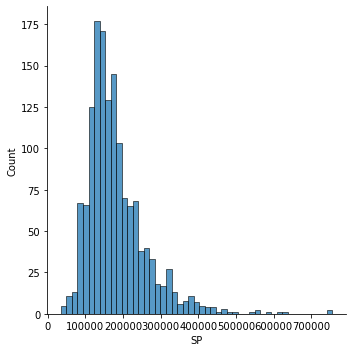

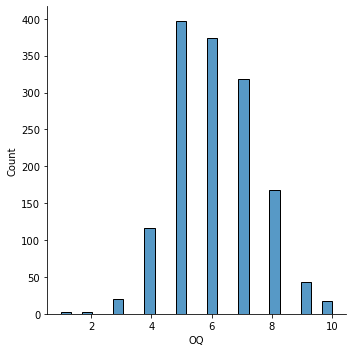

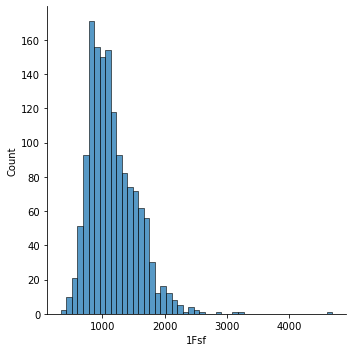

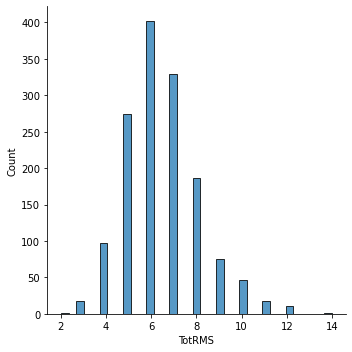

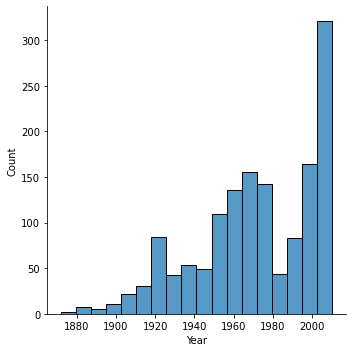

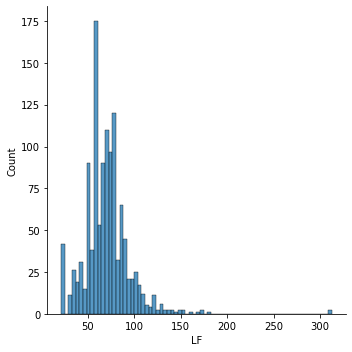

In [131]:
#Grafica de histograma
pFinal.graphHist()

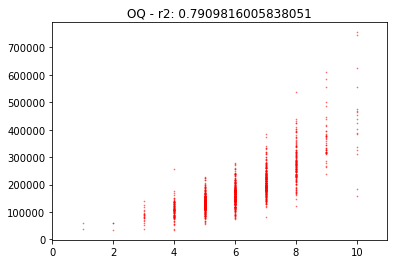

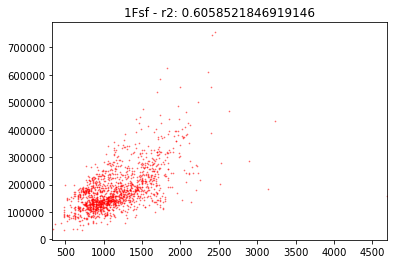

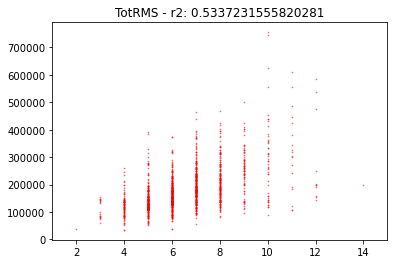

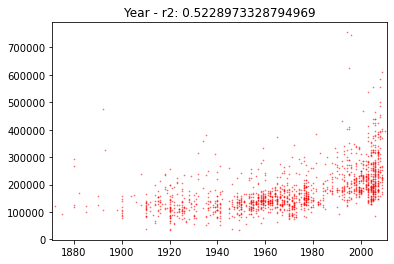

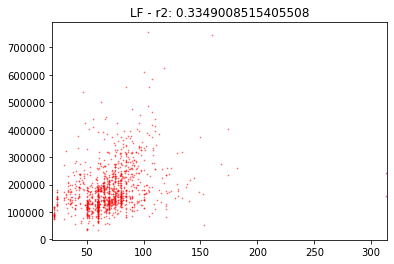

In [132]:
#Calcular coeficientes y grafica de variables independientes vs dependiente
pFinal.r2()
pFinal.plots()

## Selección de variables para entrenar.

### Variable 1 - 1Fsf - First Floor Surface

In [133]:
#Entrenar
models, errors = pFinal.entrenar(pFinal.data['1Fsf'], pFinal.data['SP'],2000,2000,0.000001)

Iteracion 2000:
 6466002762333.011


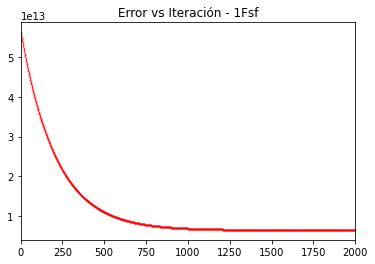

In [134]:
#Graficar error
pFinal.graphError(errors)

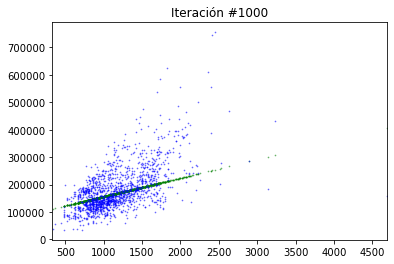

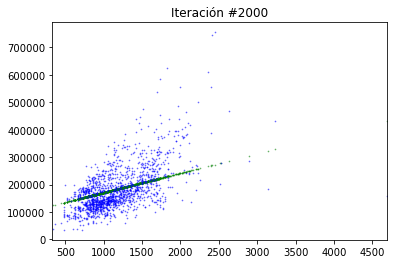

In [135]:
#Graficar modelos
pFinal.graphModels(models, 1000, True)

### Variable 2 - Year - Year

In [136]:
#Entrenar
models, errors = pFinal.entrenar(pFinal.data['Year'], pFinal.data['SP'],10000,1000,0.0001)

Iteracion 1000:
 9151943377155.29
Iteracion 2000:
 9268445541329.52
Iteracion 3000:
 9390461333140.252
Iteracion 4000:
 9518251692716.191
Iteracion 5000:
 9652089909542.088
Iteracion 6000:
 9792262206909.25
Iteracion 7000:
 9939068354026.016
Iteracion 8000:
 10092822307097.195
Iteracion 9000:
 10253852880743.48
Iteracion 10000:
 10422504451196.748


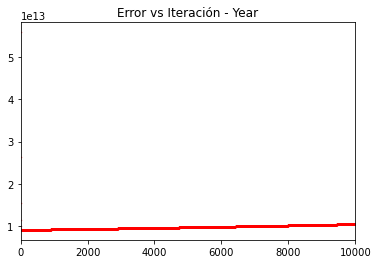

In [137]:
#Graficar error
pFinal.graphError(errors)

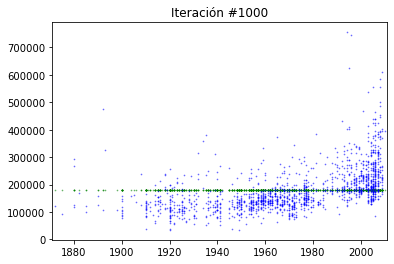

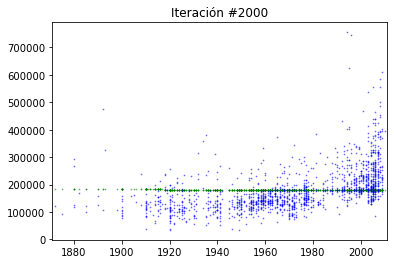

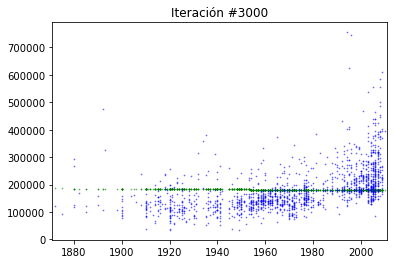

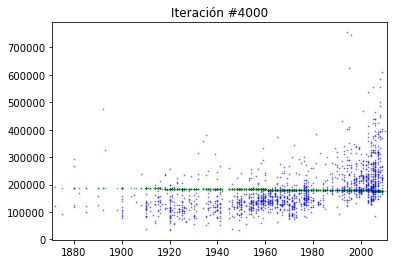

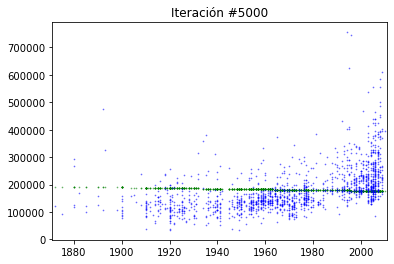

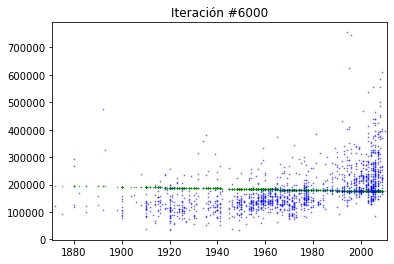

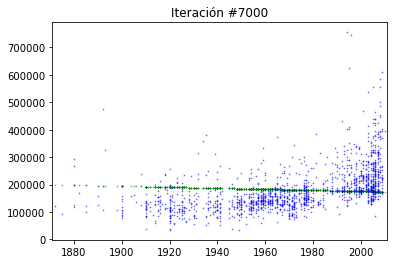

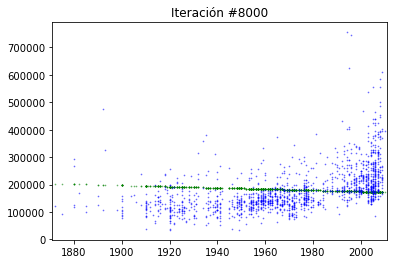

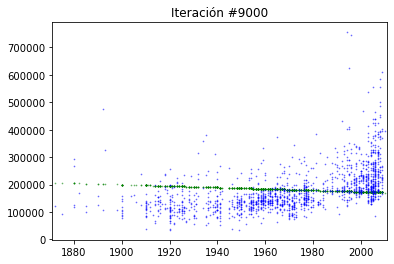

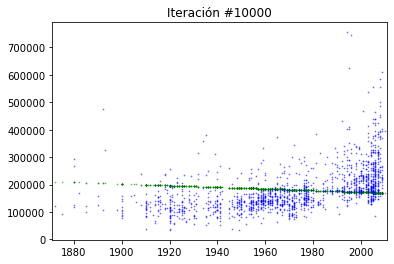

In [138]:
pFinal.graphModels(models, 1000, True)